# GLI3

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.7.1


### GLI3
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for GLI3.

In [2]:
gene_symbol = 'GLI3'
mane_tx_id = 'NM_000168.6'
mane_protein_id = 'NP_000159.3' # transcriptional activator GLI3 [Homo sapiens]

In [3]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.20") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 82 phenopackets
Individuals Processed: 100%|██████████| 82/82 [01:13<00:00,  1.11individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewable

cv = CohortViewable(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Preaxial foot polydactyly,HP:0001841,37
Postaxial hand polydactyly,HP:0001162,36
Syndactyly,HP:0001159,32
Macrocephaly,HP:0000256,28
Broad thumb,HP:0011304,19
Hypertelorism,HP:0000316,18
Postaxial polydactyly,HP:0100259,17
Y-shaped metacarpals,HP:0006042,15
Y-shaped metatarsals,HP:0010567,15
Shortening of all distal phalanges of the fingers,HP:0006118,13


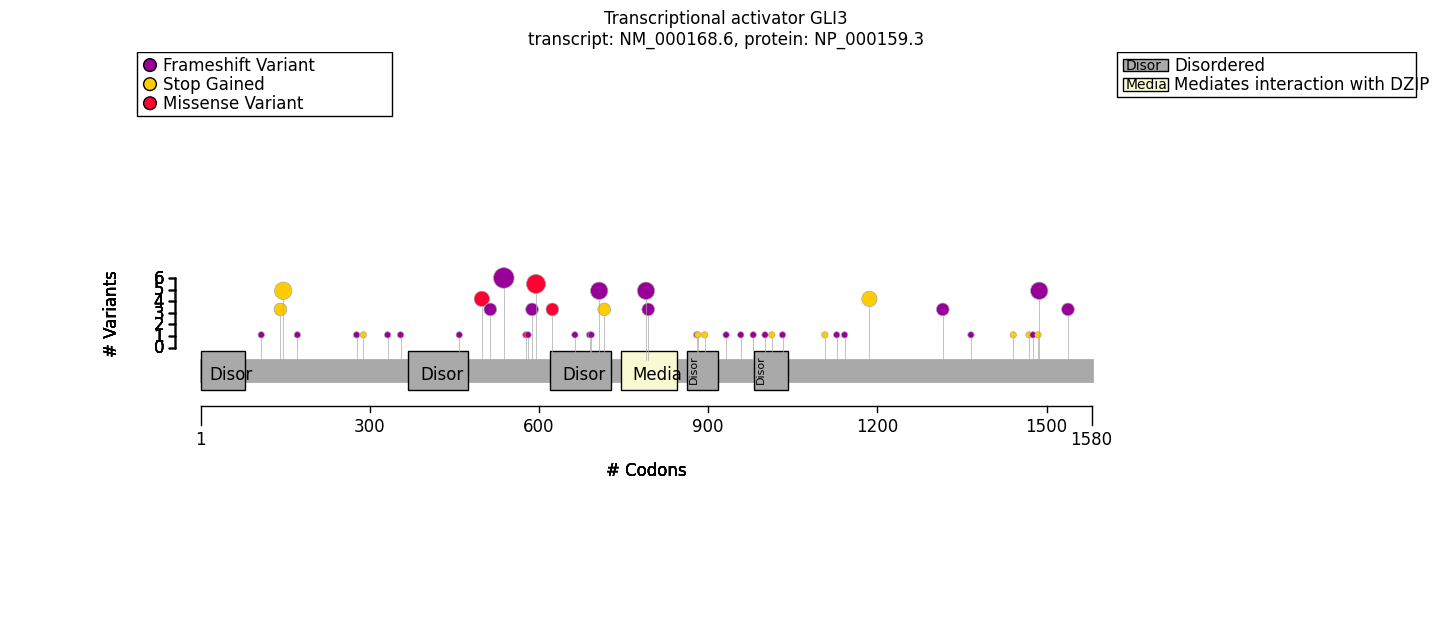

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

"""
protein_meta = ProteinMetadata.from_uniprot_json(
        protein_id=mane_protein_id,
        label="NKX6-2",
        uniprot_json="Q9C056.json",
        protein_length=550,
)
"""

fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [6]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter
from gpsea.analysis.pcats import HpoTermAnalysis

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

In [7]:
from gpsea.analysis.predicate.genotype import VariantPredicates, autosomal_dominant
from gpsea.model import VariantEffect


is_missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

gt_predicate = autosomal_dominant(
    variant_predicate=is_missense,
)

gt_predicate.display_question()

'What is the genotype group: HOM_REF, HET'

In [8]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,4
HMF04,Skipping term because all genotypes have same HPO observed proportions,39
HMF05,Skipping term because one genotype had zero observations,28
HMF06,Skipping term with less than 7 observations (not powered for 2x2),17
HMF08,Skipping general term,39


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

What is the genotype group                     HOM_REF            HET          \
                                                 Count Percent  Count Percent   
Preaxial foot polydactyly [HP:0001841]           27/71     38%  10/11     91%   
Preaxial polydactyly [HP:0100258]                27/37     73%  10/10    100%   
Postaxial foot polydactyly [HP:0001830]          11/44     25%   0/11      0%   
Y-shaped metatarsals [HP:0010567]                15/58     26%   0/11      0%   
Y-shaped metacarpals [HP:0006042]                15/68     22%   0/11      0%   
Postaxial hand polydactyly [HP:0001162]          32/54     59%   4/11     36%   
Broad thumb [HP:0011304]                         17/18     94%    2/3     67%   
Hypertelorism [HP:0000316]                       13/42     31%   5/10     50%   
Hypoplasia of the corpus callosum [HP:0002079]    3/11     27%    1/1    100%   
Ventriculomegaly [HP:0002119]                     6/14     43%    1/1    100%   
Syndactyly [HP:0001159]                          29/44     66%   9/11     82%   
Macrocephaly [HP:0000256]                        23/47     49%   5/11     45%   
Postaxial polydactyly [HP:0100259]               49/53     92%    4/4    100%   
Broad hallux [HP:0010055]                        10/18     56%    2/3     67%   
Cutaneous finger syndactyly [HP:0010554]          6/25     24%    0/2      0%   
Cutaneous syndactyly [HP:0012725]                 6/21     29%    0/2      0%   
Finger syndactyly [HP:0006101]                    6/21     29%    0/2      0%   
Cutaneous syndactyly of toes [HP:0010621]         6/25     24%    0/2      0%   
Toe syndactyly [HP:0001770]                       6/21     29%    0/2      0%   
Agenesis of corpus callosum [HP:0001274]          4/11     36%    0/1      0%   

What is the genotype group                                                   
                                               Corrected p values  p values  
Preaxial foot polydactyly [HP:0001841]                   0.038108  0.001905  
Preaxial polydactyly [HP:0100258]                        0.447614  0.091348  
Postaxial foot polydactyly [HP:0001830]                  0.447614  0.095939  
Y-shaped metatarsals [HP:0010567]                        0.447614  0.104897  
Y-shaped metacarpals [HP:0006042]                        0.447614  0.111903  
Postaxial hand polydactyly [HP:0001162]                  0.654859  0.196458  
Broad thumb [HP:0011304]                                 0.716964  0.271429  
Hypertelorism [HP:0000316]                               0.716964  0.286785  
Hypoplasia of the corpus callosum [HP:0002079]           0.740741  0.333333  
Ventriculomegaly [HP:0002119]                            0.856457  0.466667  
Syndactyly [HP:0001159]                                  0.856457  0.471051  
Macrocephaly [HP:0000256]                                1.000000  1.000000  
Postaxial polydactyly [HP:0100259]                       1.000000  1.000000  
Broad hallux [HP:0010055]                                1.000000  1.000000  
Cutaneous finger syndactyly [HP:0010554]                 1.000000  1.000000  
Cutaneous syndactyly [HP:0012725]                        1.000000  1.000000  
Finger syndactyly [HP:0006101]                           1.000000  1.000000  
Cutaneous syndactyly of toes [HP:0010621]                1.000000  1.000000  
Toe syndactyly [HP:0001770]                              1.000000  1.000000  
Agenesis of corpus callosum [HP:0001274]                 1.000000  1.000000

In [10]:
from gpsea.analysis.predicate.genotype import diagnosis_predicate
gt_predicate = diagnosis_predicate(
    diagnoses=('OMIM:175700', 'OMIM:146510'),
    labels=('Greig cephalopolysyndactyly syndrome', 'Pallister-Hall syndrome'),
)
gt_predicate.display_question()


'What disease was diagnosed: OMIM:175700, OMIM:146510'

In [11]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=result)

What disease was diagnosed              OMIM:175700         OMIM:146510  \
                                              Count Percent       Count   
Y-shaped metacarpals [HP:0006042]              0/51      0%       15/18   
Y-shaped metatarsals [HP:0010567]              0/51      0%       15/18   
Preaxial foot polydactyly [HP:0001841]        37/51     73%        0/21   
Nail dysplasia [HP:0002164]                    0/51      0%        9/13   
Anal atresia [HP:0002023]                      0/51      0%       10/21   
Postaxial polydactyly [HP:0100259]            26/26    100%       17/21   
Postaxial hand polydactyly [HP:0001162]       26/51     51%         0/4   
Postaxial foot polydactyly [HP:0001830]       11/51     22%         0/4   

What disease was diagnosed                                          \
                                        Percent Corrected p values   
Y-shaped metacarpals [HP:0006042]           83%       5.757856e-12   
Y-shaped metatarsals [HP:0010567]           83%       5.757856e-12   
Preaxial foot polydactyly [HP:0001841]       0%       8.006491e-09   
Nail dysplasia [HP:0002164]                 69%       5.192337e-08   
Anal atresia [HP:0002023]                   48%       1.052467e-06   
Postaxial polydactyly [HP:0100259]          81%       4.473972e-02   
Postaxial hand polydactyly [HP:0001162]      0%       1.296850e-01   
Postaxial foot polydactyly [HP:0001830]      0%       5.728431e-01   

What disease was diagnosed                             
                                             p values  
Y-shaped metacarpals [HP:0006042]        1.439464e-12  
Y-shaped metatarsals [HP:0010567]        1.439464e-12  
Preaxial foot polydactyly [HP:0001841]   3.002434e-09  
Nail dysplasia [HP:0002164]              2.596169e-08  
Anal atresia [HP:0002023]                6.577922e-07  
Postaxial polydactyly [HP:0100259]       3.355479e-02  
Postaxial hand polydactyly [HP:0001162]  1.134744e-01  
Postaxial foot polydactyly [HP:0001830]  5.728431e-01